In [1]:
from SparseComp import sparsecomp 
from SparseComp import data as scd
import torch as t
import numpy as np
from synthetic_model import gen_matrices, optimal_A, mean, variance
import DiagAModel as dm
from matplotlib import pyplot as plt

from tqdm import tqdm

import importlib
importlib.reload(dm)

<module 'DiagAModel' from '/Users/alexinf/Library/CloudStorage/Dropbox/github/InterpretabilityResearch/SparseComp/notebook presentation/DiagAModel.py'>

In [2]:
k = 20
n_dense = 40
n_sparse = 100
feature_probability = 0.03

def sparsefunc(x): return x
dataconfig = sparsecomp.data.Config(feature_probability, n_sparse, (0, 1), sparsefunc)
datafactory = sparsecomp.data.DataFactory(dataconfig)
device = 'cpu'


In [3]:
Win, Wout = gen_matrices(n_sparse, n_dense, k)
Win = t.tensor(Win).float()
Wout = t.tensor(Wout).float()
model = dm.DiagAModel(Win=Win, Wout=Wout, scalar_of_Identity=False)

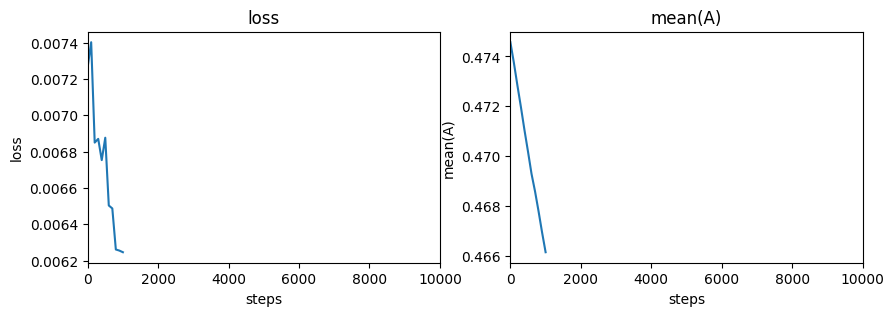

KeyboardInterrupt: 

In [4]:
print(model.compute_loss(datafactory, batch_size=1000))
losses = model.optimize(datafactory, n_iter=10000, batch_size=1000, learning_rate=2*1e-4)
print(model.compute_loss(datafactory, batch_size=1000))



In [4]:
np.ndarray

numpy.ndarray

In [14]:
opt_A = optimal_A(mean(k, n_dense, n_sparse, feature_probability), variance(k, n_dense, n_sparse, feature_probability)**.5, feature_probability)[0]
opt_A

0.4249138662885317

In [15]:
model.set_A(opt_A)
print(model.compute_loss(datafactory, batch_size=1000))

0.018772829324007034


In [9]:
# Small k example
k=10
Win, Wout = gen_matrices(n_sparse, n_dense, k)
Win = t.tensor(Win).float()
Wout = t.tensor(Wout).float()
W = Wout @ Win
model = DiagAModel(Win=Win, Wout=Wout, scalar_of_Identity=True)

test_As = np.linspace(0, 2, 100)
losses = []

for test_A in test_As:
    model.set_A(float(test_A))
    losses.append(model.compute_loss(datafactory, batch_size=10000))

plt.plot(test_As, losses)

# model.set_A = 0.1
# model.compute_loss(datafactory, batch_size=1000)

TypeError: Variable data has to be a tensor, but got float

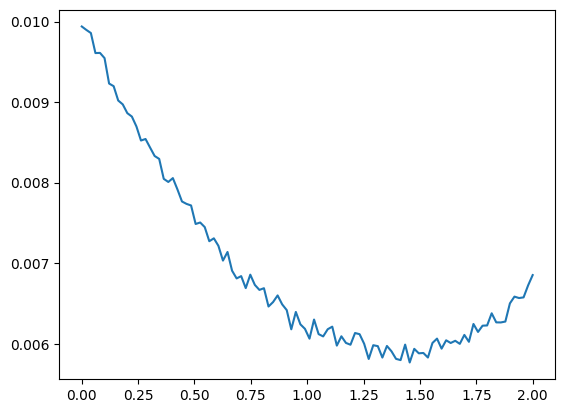

In [14]:
# Small k example
k=10
Win, Wout = gen_matrices(n_sparse, n_dense, k)
Win = t.tensor(Win).float()
Wout = t.tensor(Wout).float()
W = Wout @ Win
model = DiagAModel(Win=Win, Wout=Wout, scalar_of_Identity=False)

test_As = np.linspace(0, 2, 100)
losses = []

for test_A in test_As:
    model.set_A(float(test_A)*t.diag(t.eye(n_sparse)))
    losses.append(model.compute_loss(datafactory, batch_size=10000))

plt.plot(test_As, losses)

# model.set_A = 0.1
# model.compute_loss(datafactory, batch_size=1000)

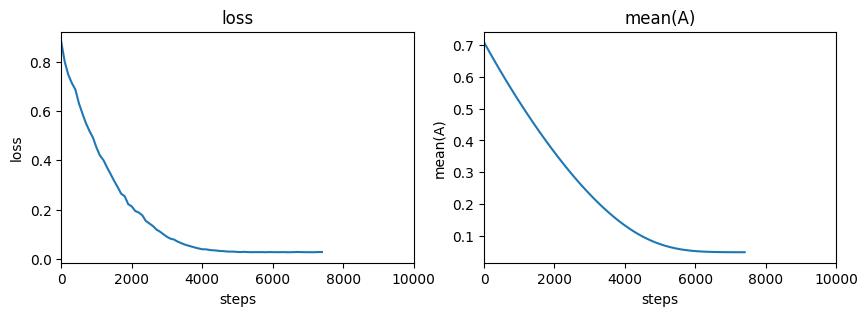

KeyboardInterrupt: 

In [31]:
# Compute the optimal A for various k

list_of_k = [5, 10, 15, 20, 25, 30, 35, 40]
list_of_A = []
list_of_trained_A = []
list_of_losses = []

for k in list_of_k:
    Win, Wout = gen_matrices(n_sparse, n_dense, k)
    Win = t.tensor(Win).float()
    Wout = t.tensor(Wout).float()
    W = Wout @ Win
    model = DiagAModel(W, scalar_of_Identity=True)
    opt_A = optimal_A(mean(k, n_dense, n_sparse, feature_probability), variance(k, n_dense, n_sparse, feature_probability)**.5, feature_probability)[0]
    list_of_A.append(opt_A)
    losses = model.optimize(datafactory, n_iter=10000, batch_size=1000, learning_rate=2*1e-4)
    list_of_losses.append(losses[-1])
    list_of_trained_A.append(model.Adiag)



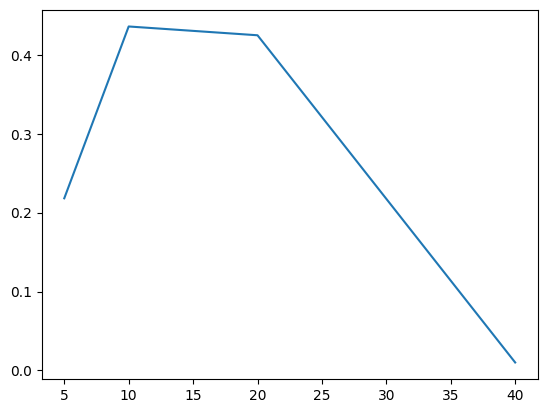

In [29]:
plt.plot(list_of_k, list_of_trained_A)

In [30]:
list_of_A

[0.218187610468871,
 0.4360639405833689,
 0.4249138662885317,
 0.010001002456613369]

In [50]:
test_matrix = t.tensor([[1, 2], [3, 4]])
scaling_vector = t.tensor([1, 2]).reshape(-1, 1)
print(scaling_vector.shape)
print(scaling_vector)
print(test_matrix)
print(scaling_vector * test_matrix)

torch.Size([2, 1])
tensor([[1],
        [2]])
tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [6, 8]])


# Comparing Optimization to Brute Force

In [37]:
n_dense = 40
n_sparse = 100
feature_probability = 0.03

def sparsefunc(x): return x
dataconfig = sparsecomp.data.Config(feature_probability, n_sparse, (0, 1), sparsefunc)
datafactory = sparsecomp.data.DataFactory(dataconfig)
device = 'cpu'



<module 'DiagAModel' from '/Users/alexinf/Library/CloudStorage/Dropbox/github/InterpretabilityResearch/SparseComp/notebook presentation/DiagAModel.py'>

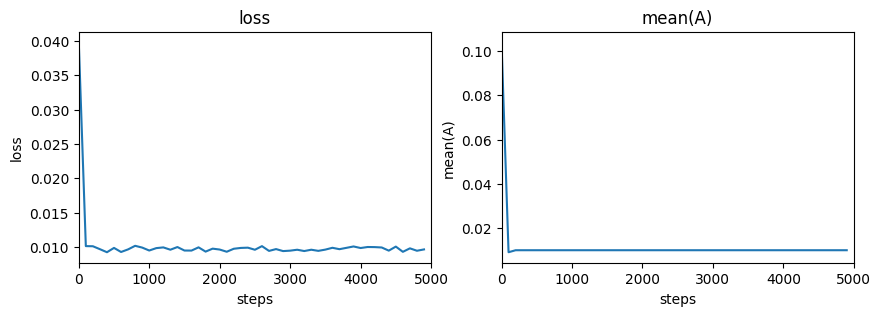

In [31]:
list_of_k = [5, 10, 15, 20, 25, 30, 35, 40]
list_of_A_bf = []
list_of_A_trained = []
list_of_theory_A = []
for k in list_of_k:
    Win, Wout = gen_matrices(n_sparse, n_dense, k)
    Win = t.tensor(Win).float()
    Wout = t.tensor(Wout).float()
    model = dm.DiagAModel(Win=Win, Wout=Wout, scalar_of_Identity=True)
    theory_A = optimal_A(mean(k, n_dense, n_sparse, feature_probability), variance(k, n_dense, n_sparse, feature_probability)**.5, feature_probability)[0]
    list_of_theory_A.append(theory_A)

    model.optimize(datafactory, n_iter = 5000)
    list_of_A_trained.append(model.Adiag.detach().numpy())

    model.brute_force_optimize(datafactory)
    list_of_A_bf.append(model.Adiag.detach().numpy())



Text(0.5, 1.0, 'Optimal A for various k, Scalar of Identity Case')

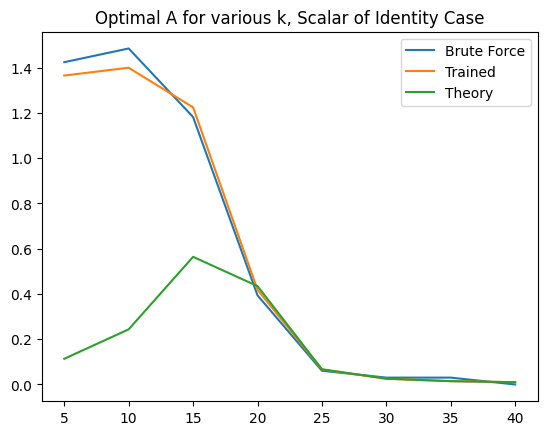

In [33]:
plt.plot(list_of_k, list_of_A_bf, label='Brute Force')
plt.plot(list_of_k, list_of_A_trained, label='Trained')
plt.plot(list_of_k, list_of_theory_A, label='Theory')
plt.legend()
plt.title("Optimal A for various k, Scalar of Identity Case")

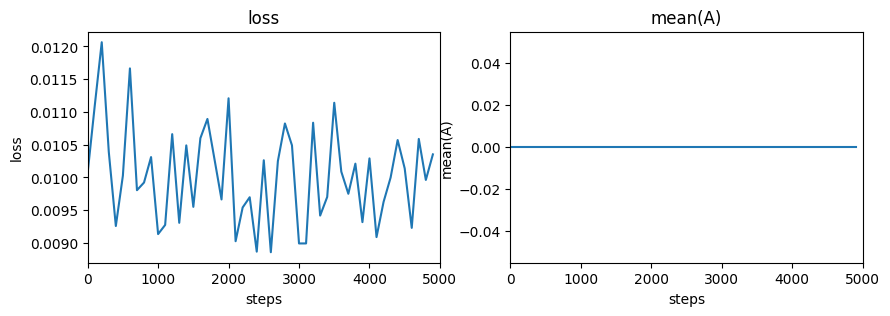

100%|██████████| 8/8 [00:41<00:00,  5.13s/it]


In [21]:
list_of_k = [5, 10, 15, 20, 25, 30, 35, 40]
list_of_A_bf = []
list_of_A_trained = []
list_of_theory_A = []
importlib.reload(dm)

trained_losses = []
bf_losses = []

for k in tqdm(list_of_k):
    Win, Wout = gen_matrices(n_sparse, n_dense, k)
    Win = t.tensor(Win).float()
    Wout = t.tensor(Wout).float()
    model = dm.DiagAModel(Win=Win, Wout=Wout, scalar_of_Identity=False)

    model.brute_force_optimize(datafactory)
    list_of_A_bf.append(model.Adiag.detach().numpy())
    bf_losses.append(model.compute_loss(datafactory, batch_size=1000))

    model.optimize(datafactory, n_iter = 5000)
    list_of_A_trained.append(model.Adiag.detach().numpy())
    trained_losses.append(model.compute_loss(datafactory, batch_size=1000))

    



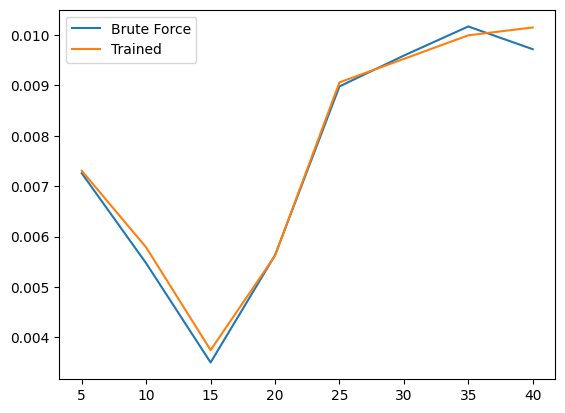

In [22]:
plt.plot(list_of_k, bf_losses, label='Brute Force')
plt.plot(list_of_k, trained_losses, label='Trained')
plt.legend()
# plt.title("Optimal A for various k, Heterogeneous A Case")

Text(0.5, 1.0, 'Optimal A for various k, Heterogeneous A Case')

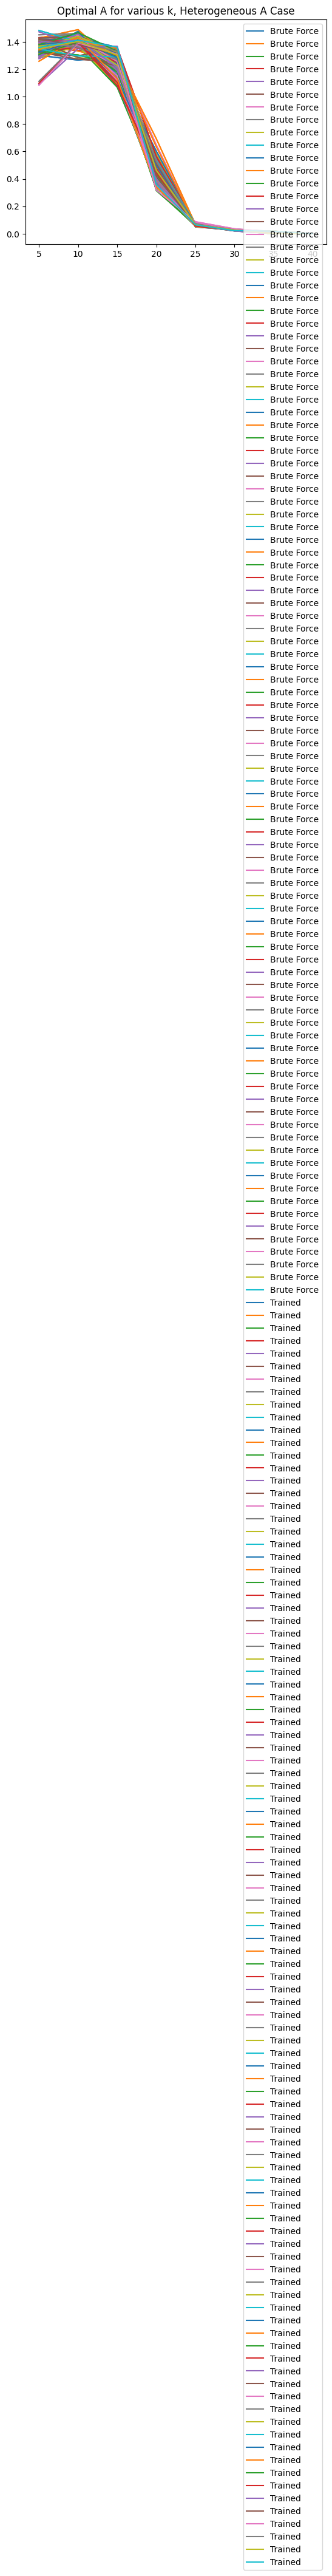

In [17]:
plt.plot(list_of_k, list_of_A_bf, label='Brute Force')
plt.plot(list_of_k, list_of_A_trained, label='Trained')
# plt.plot(list_of_k, list_of_theory_A, label='Theory')
plt.legend()
plt.title("Optimal A for various k, Heterogeneous A Case")